In [1]:
import cmocean 
import cosima_cookbook as cc
import dask.distributed as dsk
import gsw
import glob
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

figdir = '/home/561/jn8053/g_e14/figures-tmp/easterlies-collaborative/'

clnt = dsk.Client()
clnt

Client Scheduler: tcp://127.0.0.1:40431 Dashboard: /proxy/42027/status,Cluster Workers: 4 Cores: 16 Memory: 200.00 GiB


Load datasets

In [2]:
session_ryf = cc.database.create_session()
experiment_ryf = '01deg_jra55v13_ryf9091'
session_eas = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
experiment_eup = '01deg_jra55v13_ryf9091_easterlies_up10'
experiment_edo = '01deg_jra55v13_ryf9091_easterlies_down10'
easterlies_up_zonal = '01deg_jra55v13_ryf9091_easterlies_up10_zonal'
easterlies_up_meridional = '01deg_jra55v13_ryf9091_easterlies_up10_meridional'
easterlies_up_noDSW = '01deg_jra55v13_ryf9091_easterlies_up10_noDSW'

ti = '2150-01-01'
tf = '2159-12-31'

In [3]:
ht = cc.querying.getvar(experiment_ryf, 'ht', session_ryf, n = 1).sel(yt_ocean = slice(None, -58))

In [4]:
slev = {}
slev['ctrl'] = cc.querying.getvar(experiment_ryf, 'sea_level', session_ryf, start_time = ti, end_time = tf).sel(time = slice(ti, '2169-12-31'), yt_ocean = slice(None, -58))
slev['up'] = cc.querying.getvar(experiment_eup, 'sea_level', session_eas, start_time = ti, end_time = tf).sel(yt_ocean = slice(None, -58))
slev['up_zon'] = cc.querying.getvar(easterlies_up_zonal, 'sea_level', session_eas, start_time = ti, end_time = tf).sel(yt_ocean = slice(None, -58))
slev['up_mer'] = cc.querying.getvar(easterlies_up_meridional, 'sea_level', session_eas, start_time = ti, end_time = tf).sel(yt_ocean = slice(None, -58))

# Time series for continental shelf

### Sea level

In [5]:
lat_slice = slice(-80,-58)
lon_slice = slice(-280, 80)

def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    # Mask values that are non-zero
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map = xr.DataArray(shelf_map, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    # Multiply the variable with the mask, we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = lat_slice) * shelf_mask
    return masked_var, shelf_map

In [6]:
slev_mask = {}
for k in ['ctrl', 'up', 'up_zon', 'up_mer']:
    slev_mask[k], shelf_mask = shelf_mask_isobath(slev[k])

In [7]:
# Area for weighting
area_t = cc.querying.getvar(experiment_ryf, 'area_t', session_ryf, ncfile = 'ocean_grid.nc', n = -1)
area_t = area_t.sel(yt_ocean = lat_slice).sel(xt_ocean = lon_slice)
area_t = area_t * shelf_mask.sel(yt_ocean = lat_slice).sel(xt_ocean = lon_slice)
area_sum = area_t.sum('xt_ocean').sum('yt_ocean')

In [8]:
slev_clim_control = ((slev_mask['ctrl']*area_t).sum('xt_ocean').sum('yt_ocean') / area_sum).groupby('time.month').mean('time')
slev_anom_mask = {}
for k in ['up', 'up_zon', 'up_mer']:
    slev_anom_mask[k] = ((slev_mask[k]*area_t).sum('xt_ocean').sum('yt_ocean') / area_sum).groupby('time.month') - slev_clim_control

## DSW

In [9]:
path_ctrl = np.sort(glob.glob('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_rerun_for_easterlies//Antarctic_cross_slope/*'))

vol_transp_ctrl = xr.open_dataset('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_rerun_for_easterlies//Antarctic_cross_slope/vol_trans_across_contour_2150_01.nc')

for i in range(1, len(path_ctrl)):
    vol_transp_ctrl = xr.concat([vol_transp_ctrl, xr.open_dataset(path_ctrl[i])], dim = 'time')
    
vol_transp_ctrl['time'] = slev_anom_mask['up']['time'].values
vol_transp_ctrl_total = (vol_transp_ctrl['vol_trans_across_contour_binned']*vol_transp_ctrl['ndays']).sum('time')/np.sum(vol_transp_ctrl['ndays'])

In [10]:
path_up = np.sort(glob.glob('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/Antarctic_cross_slope/*'))[0:120]

vol_transp_up = xr.open_dataset('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/Antarctic_cross_slope/vol_trans_across_contour_2150_01.nc')

for i in range(1, len(path_up)):
    vol_transp_up = xr.concat([vol_transp_up, xr.open_dataset(path_up[i])], dim = 'time')
    
vol_transp_up['time'] = slev_anom_mask['up']['time'].values
vol_transp_up_total = (vol_transp_up['vol_trans_across_contour_binned']*vol_transp_up['ndays']).sum('time')/np.sum(vol_transp_up['ndays'])

In [11]:
path_up_z = np.sort(glob.glob('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10_zonal//Antarctic_cross_slope/*'))[0:120]

vol_transp_up_z = xr.open_dataset('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/Antarctic_cross_slope/vol_trans_across_contour_2150_01.nc')

for i in range(1, len(path_up_z)):
    vol_transp_up_z = xr.concat([vol_transp_up_z, xr.open_dataset(path_up_z[i])], dim = 'time')
    
vol_transp_up_z['time'] = slev_anom_mask['up']['time'].values
vol_transp_up_z_total = (vol_transp_up_z['vol_trans_across_contour_binned']*vol_transp_up_z['ndays']).sum('time')/np.sum(vol_transp_up_z['ndays'])

In [12]:
path_up_m = np.sort(glob.glob('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10_meridional//Antarctic_cross_slope/*'))[0:120]

vol_transp_up_m = xr.open_dataset('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/Antarctic_cross_slope/vol_trans_across_contour_2150_01.nc')

for i in range(1, len(path_up_m)):
    vol_transp_up_m = xr.concat([vol_transp_up_m, xr.open_dataset(path_up_m[i])], dim = 'time')
    
vol_transp_up_m['time'] = slev_anom_mask['up']['time'].values
vol_transp_up_m_total = (vol_transp_up_m['vol_trans_across_contour_binned']*vol_transp_up_m['ndays']).sum('time')/np.sum(vol_transp_up_m['ndays'])

In [13]:
vol_transp_ct_tv = vol_transp_ctrl['vol_trans_across_contour_binned']
vol_transp_up_tv = vol_transp_up['vol_trans_across_contour_binned']
vol_transp_upz_tv = vol_transp_up_z['vol_trans_across_contour_binned']
vol_transp_upm_tv = vol_transp_up_m['vol_trans_across_contour_binned']

trans_sum_ct_tv = vol_transp_ct_tv.sum('contour_index')
trans_sum_up_tv = vol_transp_up_tv.sum('contour_index')
trans_sum_upz_tv = vol_transp_upz_tv.sum('contour_index')
trans_sum_upm_tv = vol_transp_upm_tv.sum('contour_index')

psi_ct_tv = trans_sum_ct_tv[:,::-1].cumsum('isopycnal_bins')[:, ::-1]
psi_up_tv = trans_sum_up_tv[:,::-1].cumsum('isopycnal_bins')[:, ::-1]
psi_upz_tv = trans_sum_upz_tv[:,::-1].cumsum('isopycnal_bins')[:, ::-1]
psi_upm_tv = trans_sum_upm_tv[:,::-1].cumsum('isopycnal_bins')[:, ::-1]

In [14]:
DSW_export_ct = np.empty(len(psi_ct_tv['time']))
DSW_export_up = np.empty(len(psi_up_tv['time']))
DSW_export_upz = np.empty(len(psi_upz_tv['time']))
DSW_export_upm = np.empty(len(psi_upm_tv['time']))

# find max DSW density:
DSW_top_density_ct = psi_ct_tv.argmax('isopycnal_bins')
# find max DSW density:
DSW_top_density_up = psi_up_tv.argmax('isopycnal_bins')
# find max DSW density:
DSW_top_density_upz = psi_upz_tv.argmax('isopycnal_bins')
# find max DSW density:
DSW_top_density_upm = psi_upm_tv.argmax('isopycnal_bins')

n = 0
for t in psi_up_tv['time']:
    
    # sum over DSW layer:
    DSW_trans_ct = psi_ct_tv.sel(time = t).isel(isopycnal_bins = int(DSW_top_density_ct.sel(time = t)))
    DSW_export_ct[n] = DSW_trans_ct.item()/1e6
    
    # sum over DSW layer:
    DSW_trans_up = psi_up_tv.sel(time = t).isel(isopycnal_bins = int(DSW_top_density_up.sel(time = t)))
    DSW_export_up[n] = DSW_trans_up.item()/1e6
    
    # sum over DSW layer:
    DSW_trans_upz = psi_upz_tv.sel(time = t).isel(isopycnal_bins = int(DSW_top_density_upz.sel(time = t)))
    DSW_export_upz[n] = DSW_trans_upz.item()/1e6
    
    # sum over DSW layer:
    DSW_trans_upm = psi_upm_tv.sel(time = t).isel(isopycnal_bins = int(DSW_top_density_upm.sel(time = t)))
    DSW_export_upm[n] = DSW_trans_upm.item()/1e6
    n += 1

In [15]:
DSW_export_ct = xr.DataArray(DSW_export_ct, dims = ['time'], coords = {'time':slev_anom_mask['up']['time']})
DSW_export_up = xr.DataArray(DSW_export_up, dims = ['time'], coords = {'time':slev_anom_mask['up']['time']})
DSW_export_upz = xr.DataArray(DSW_export_upz, dims = ['time'], coords = {'time':slev_anom_mask['up']['time']})
DSW_export_upm = xr.DataArray(DSW_export_upm, dims = ['time'], coords = {'time':slev_anom_mask['up']['time']})

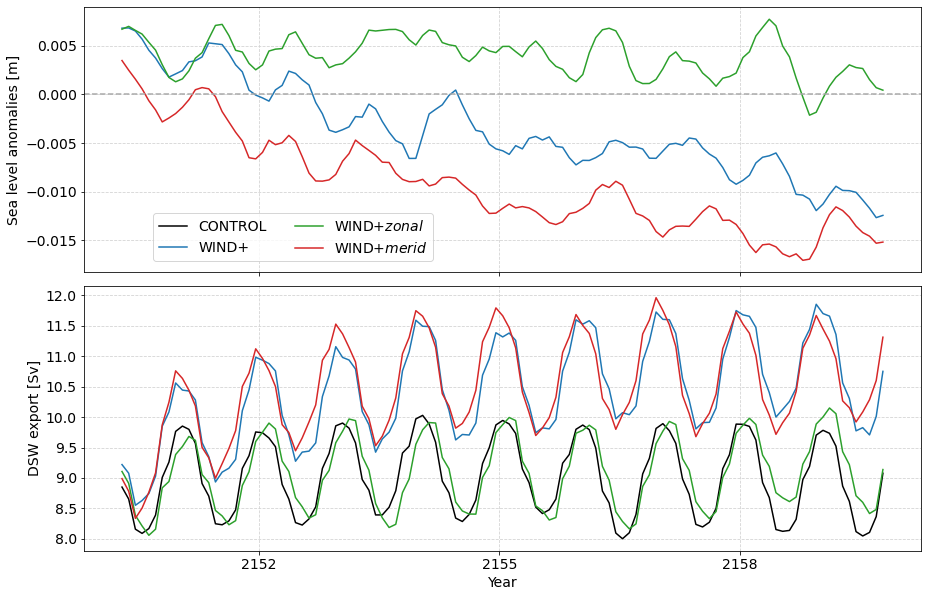

In [27]:
fig = plt.figure(figsize = (15, 10))
axs = [fig.add_subplot(211), fig.add_subplot(212)]
plt.subplots_adjust(hspace = 0.05)

for k, clr in zip(['up', 'up_zon', 'up_mer'], ['C0', 'C2', 'C3']):
    axs[0].plot(slev_anom_mask[k].rolling(time = 6, center = True).mean('time')['time'], 
                slev_anom_mask[k].rolling(time = 6, center = True).mean('time'), color = clr)

axs[1].plot(DSW_export_ct.rolling(time = 6, center = True).mean('time')['time'], DSW_export_ct.rolling(time = 6, center = True).mean('time'), color = 'k', label = 'CONTROL')
axs[1].plot(DSW_export_up.rolling(time = 6, center = True).mean('time')['time'], DSW_export_up.rolling(time = 6, center = True).mean('time'), color = 'C0', label = 'WIND+')
axs[1].plot(DSW_export_upz.rolling(time = 6, center = True).mean('time')['time'], DSW_export_upz.rolling(time = 6, center = True).mean('time'), color = 'C2', label = 'WIND+$zonal$')
axs[1].plot(DSW_export_upm.rolling(time = 6, center = True).mean('time')['time'], DSW_export_upm.rolling(time = 6, center = True).mean('time'), color = 'C3', label = 'WIND+$merid$')
    
axs[1].legend(ncol = 2, loc = 'upper center', bbox_to_anchor = (0.25,1.3))

axs[0].set_xticklabels([])
axs[0].axhline(y = 0, color = 'darkgrey', linestyle = '--')
axs[0].grid(linestyle = '--', color = 'lightgrey')
axs[1].grid(linestyle = '--', color = 'lightgrey')
axs[0].set_ylabel('Sea level anomalies [m]')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('DSW export [Sv]')

plt.savefig(figdir+'figure-8-v1.jpg', bbox_inches = 'tight')

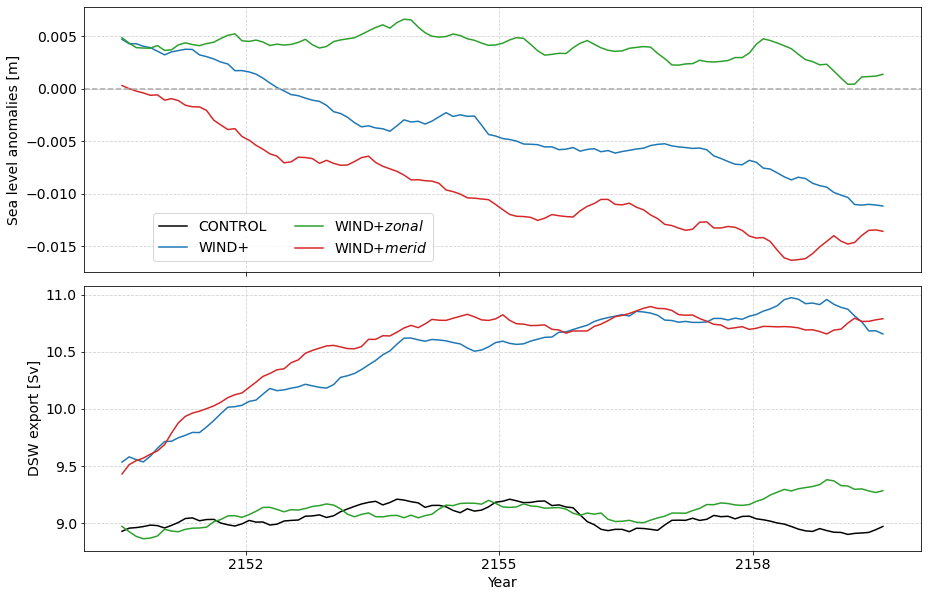

In [23]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (15, 10))
axs = [fig.add_subplot(211), fig.add_subplot(212)]
plt.subplots_adjust(hspace = 0.05)

for k, clr in zip(['up', 'up_zon', 'up_mer'], ['C0', 'C2', 'C3']):
    axs[0].plot(slev_anom_mask[k].rolling(time = 12, center = True).mean('time')['time'], 
                slev_anom_mask[k].rolling(time = 12, center = True).mean('time'), color = clr)

axs[1].plot(DSW_export_ct.rolling(time = 12, center = True).mean('time')['time'], DSW_export_ct.rolling(time = 12, center = True).mean('time'), color = 'k', label = 'CONTROL')
axs[1].plot(DSW_export_up.rolling(time = 12, center = True).mean('time')['time'], DSW_export_up.rolling(time = 12, center = True).mean('time'), color = 'C0', label = 'WIND+')
axs[1].plot(DSW_export_upz.rolling(time = 12, center = True).mean('time')['time'], DSW_export_upz.rolling(time = 12, center = True).mean('time'), color = 'C2', label = 'WIND+$zonal$')
axs[1].plot(DSW_export_upm.rolling(time = 12, center = True).mean('time')['time'], DSW_export_upm.rolling(time = 12, center = True).mean('time'), color = 'C3', label = 'WIND+$merid$')
    
axs[1].legend(ncol = 2, loc = 'upper center', bbox_to_anchor = (0.25,1.3))

axs[0].set_xticklabels([])
axs[0].axhline(y = 0, color = 'darkgrey', linestyle = '--')
axs[0].grid(linestyle = '--', color = 'lightgrey')
axs[1].grid(linestyle = '--', color = 'lightgrey')
axs[0].set_ylabel('Sea level anomalies [m]')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('DSW export [Sv]')

plt.savefig(figdir+'figure-8-v2.jpg', bbox_inches = 'tight')

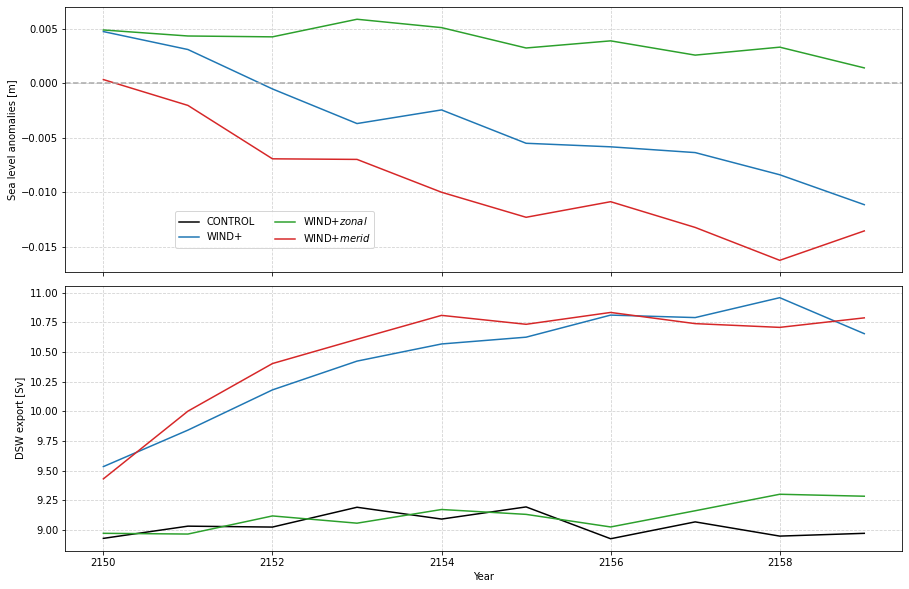

In [19]:
fig = plt.figure(figsize = (15, 10))
axs = [fig.add_subplot(211), fig.add_subplot(212)]
plt.subplots_adjust(hspace = 0.05)

for k, clr in zip(['up', 'up_zon', 'up_mer'], ['C0', 'C2', 'C3']):
    axs[0].plot(slev_anom_mask[k].groupby('time.year').mean('time')['year'], 
                slev_anom_mask[k].groupby('time.year').mean('time'), color = clr)

axs[1].plot(DSW_export_ct.groupby('time.year').mean('time')['year'], DSW_export_ct.groupby('time.year').mean('time'), color = 'k', label = 'CONTROL')
axs[1].plot(DSW_export_up.groupby('time.year').mean('time')['year'], DSW_export_up.groupby('time.year').mean('time'), color = 'C0', label = 'WIND+')
axs[1].plot(DSW_export_upz.groupby('time.year').mean('time')['year'], DSW_export_upz.groupby('time.year').mean('time'), color = 'C2', label = 'WIND+$zonal$')
axs[1].plot(DSW_export_upm.groupby('time.year').mean('time')['year'], DSW_export_upm.groupby('time.year').mean('time'), color = 'C3', label = 'WIND+$merid$')
    
axs[1].legend(ncol = 2, loc = 'upper center', bbox_to_anchor = (0.25,1.3))

axs[0].set_xticklabels([])
axs[0].axhline(y = 0, color = 'darkgrey', linestyle = '--')
axs[0].grid(linestyle = '--', color = 'lightgrey')
axs[1].grid(linestyle = '--', color = 'lightgrey')
axs[0].set_ylabel('Sea level anomalies [m]')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('DSW export [Sv]')

plt.savefig(figdir+'figure-8-v3.jpg', bbox_inches = 'tight')

In [20]:
DSW_export_anom = {}
DSW_export_anom['up'] = DSW_export_up.groupby('time.month') - DSW_export_ct.groupby('time.month').mean('time')
DSW_export_anom['up_zon'] = DSW_export_upz.groupby('time.month') - DSW_export_ct.groupby('time.month').mean('time')
DSW_export_anom['up_mer'] = DSW_export_upm.groupby('time.month') - DSW_export_ct.groupby('time.month').mean('time')

distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


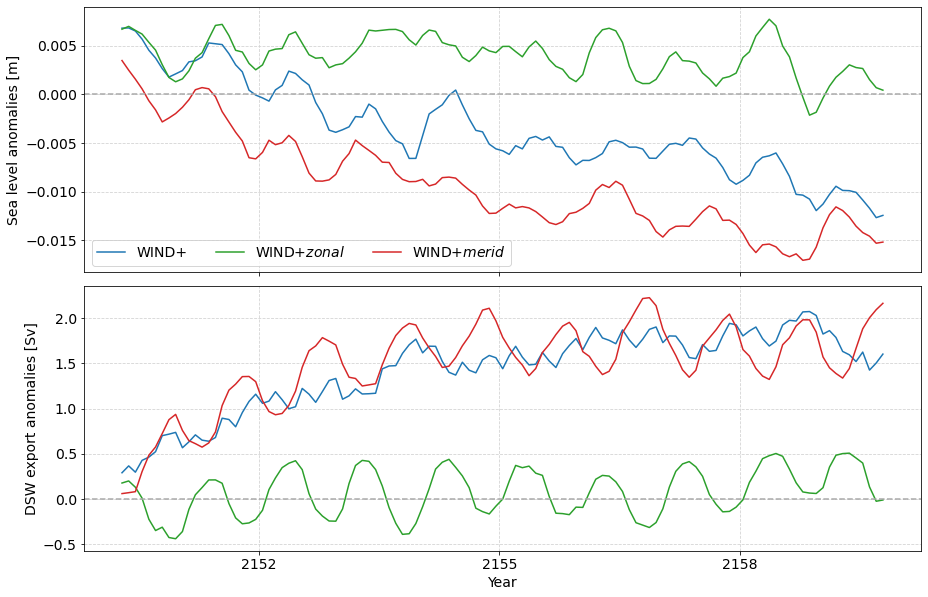

In [25]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (15, 10))
axs = [fig.add_subplot(211), fig.add_subplot(212)]
plt.subplots_adjust(hspace = 0.05)

for k, clr, lb in zip(['up', 'up_zon', 'up_mer'], ['C0', 'C2', 'C3'], ['WIND+', 'WIND+$zonal$', 'WIND+$merid$']):
    axs[0].plot(slev_anom_mask[k].rolling(time = 6, center = True).mean('time')['time'], 
                slev_anom_mask[k].rolling(time = 6, center = True).mean('time'), color = clr)
    axs[1].plot(DSW_export_anom[k].rolling(time = 6, center = True).mean('time')['time'], 
                DSW_export_anom[k].rolling(time = 6, center = True).mean('time'), color = clr, label = lb)
    
axs[1].legend(ncol = 3, loc = 'upper center', bbox_to_anchor = (0.26,1.2))

axs[0].set_xticklabels([])
axs[0].axhline(y = 0, color = 'darkgrey', linestyle = '--')
axs[1].axhline(y = 0, color = 'darkgrey', linestyle = '--')
axs[0].grid(linestyle = '--', color = 'lightgrey')
axs[1].grid(linestyle = '--', color = 'lightgrey')
axs[0].set_ylabel('Sea level anomalies [m]')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('DSW export anomalies [Sv]')

plt.savefig(figdir+'figure-8-v4.jpg', bbox_inches = 'tight')